In [93]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

In [94]:
# Unsupervised learning -> Methods that extract meaning from the data without training a model on labeled data
# Clustering -> Identify meaningful groups of data
# Dimensionality reduction 
# Also viewed as a extension to EDA

In [95]:
# PCA -> Technique to discover in which way numeric variables covary
# Combine predictor variable into a smaller set, which are linear combinations of the original set
# The "principal components" (eigenvectors) try to explain most of the variability of the data (Can be viewed as a unsupervised version of LDA)
# Principal components are orthogonal to each other
# Zi = wi1X1 + wi2X2

In [96]:
df = pd.read_csv("files/data.csv")
not_important = ['id','uri','track_href','analysis_url','duration_ms','type','Popularity','seconds','Song']
dfc = df.drop(columns=not_important).select_dtypes("number")

In [97]:
cols = ['danceability','energy']

In [98]:
X = dfc[cols]
Xc = (X - X.mean()) / X.std()
pcs = PCA(n_components=2)
pcs.fit(Xc)
loadings = pd.DataFrame(pcs.components_, columns=Xc.columns)
loadings

,danceability,energy
0,-0.707107,0.707107
1,-0.707107,-0.707107


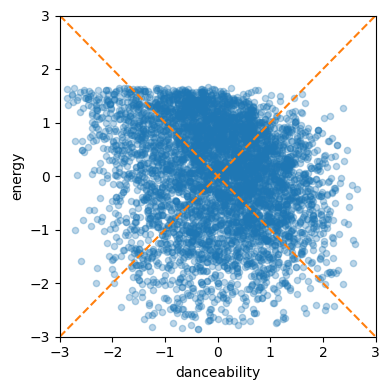

In [99]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = Xc.plot.scatter(x='danceability', y='energy', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'energy'] / loadings.loc[0, 'danceability'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'energy'] / loadings.loc[1, 'danceability'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

In [100]:
# First principal component -> PCA arrives at the linear combination of predictor variables that maximize percent of total variance explained
# Repeats this proccess, such that the first and second predictor variables are uncorrelated (orthogonal)
# SVD on the correlation matrix

Text(0.5, 0, 'Component')

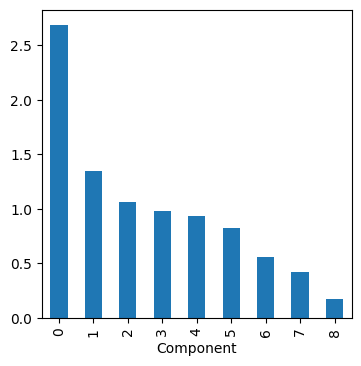

In [101]:
dfcn =(dfc - dfc.mean()) / dfc.std()
sp_pca = PCA()
sp_pca.fit(dfcn)
explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

In [102]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=dfcn.columns)
print(loadings)

   danceability    energy  loudness  speechiness  acousticness  \
0      0.106979 -0.552376 -0.516142    -0.009458      0.495318   
1     -0.722636  0.064724 -0.039393    -0.207433     -0.055242   
2     -0.065619 -0.033828 -0.091098     0.793318      0.134112   
3     -0.050929  0.055632  0.032193    -0.263387     -0.027270   
4      0.148661  0.084952 -0.160259    -0.170151      0.022456   

   instrumentalness  liveness   valence     tempo  
0          0.239457 -0.145508 -0.253324 -0.170056  
1          0.226606  0.056396 -0.509260  0.334813  
2         -0.081304  0.523854 -0.068335  0.230672  
3          0.155437  0.700867 -0.082449 -0.633234  
4          0.676115  0.231946  0.480037  0.417346  


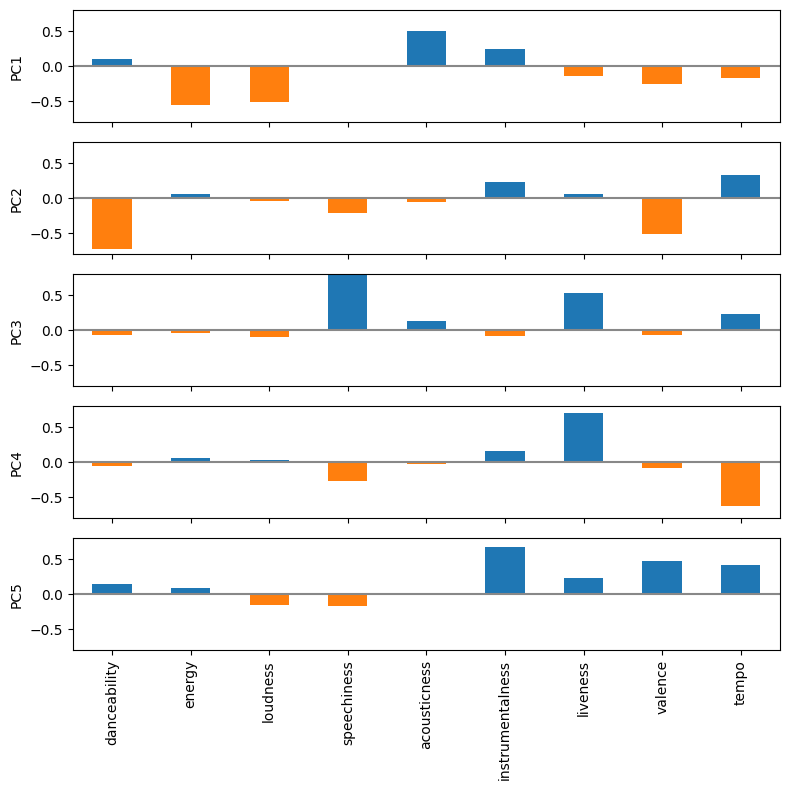

In [103]:
maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

In [104]:
dfc = df.drop(columns=not_important).select_dtypes("object")
dfc.head()

,genre,key,mode,time_signature
0,chill,E,Minor,4/4
1,chill,E,Minor,4/4
2,chill,G,Major,4/4
3,chill,F#G,Major,4/4
4,chill,F,Major,3/4


In [105]:
X = pd.crosstab(dfc['key'],dfc['genre'])

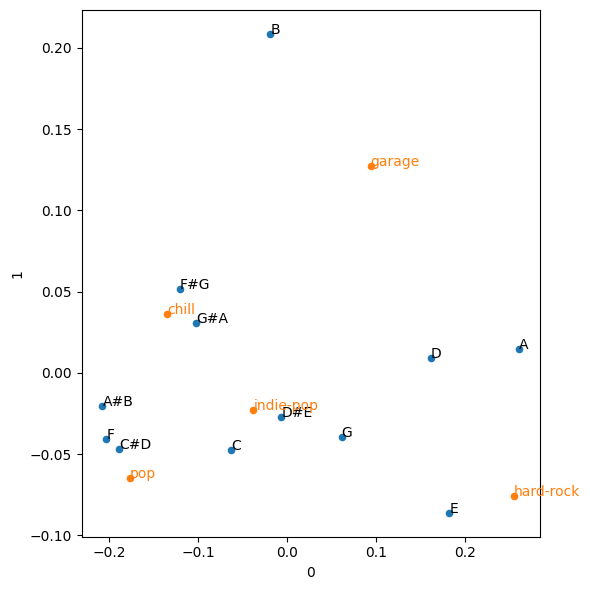

In [106]:
# Correspondence analysis 
# PCA cant be used on categorical data
ca = prince.CA(n_components=2)
ca = ca.fit(X)

ax = ca.row_coordinates(X).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(X).plot.scatter(x=0, y=1, ax=ax, c='C1')
texts = []
for idx, row in ca.row_coordinates(X).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(X).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
plt.tight_layout()
plt.show()

In [107]:
# K-Means clustering 
# Can scale to large datasets
# Divides data into k cluster minimizing the sum of squared distances of each record to the mean of its assigned cluster
# Normalize before aplying it
# Center of a cluster -> Mean of the points assigned to that cluster
# Algorithm 
# Assign each record to a the nearest cluster mean by squared distance
# Compute the new cluster mean based on this
# Init -> Assign points to random cluster 

In [108]:
dfc = df.drop(columns=not_important).select_dtypes("number")
dfcn =(dfc - dfc.mean()) / dfc.std()
X = dfcn[cols]
kmeans = KMeans(n_clusters=3, n_init='auto').fit(X)
X['cluster'] = kmeans.labels_
X.head()

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_14924\2756153334.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.labels_


,danceability,energy,cluster
0,-0.791710,-0.460266,1
1,-0.791710,-0.460266,1
2,-0.626901,-1.065757,1
3,-0.560978,-2.010689,1
4,-1.226804,-1.969405,1


In [109]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=cols)
print(centers)

   danceability    energy
0     -0.781112  0.802027
1     -0.227134 -1.281409
2      0.896361  0.037483


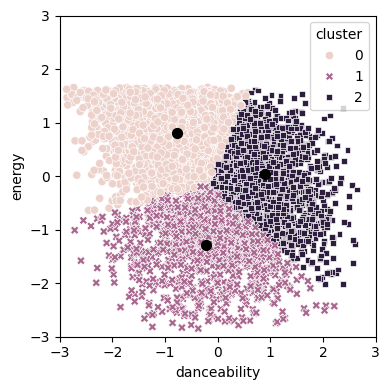

In [110]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='danceability', y='energy', hue='cluster', style='cluster', 
                     ax=ax, data=X)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='danceability', y='energy', ax=ax, s=50, color='black')
plt.tight_layout()
plt.show()

In [111]:
from collections import Counter
Counter(kmeans.labels_)

Counter({2: 1920, 0: 1856, 1: 1224})

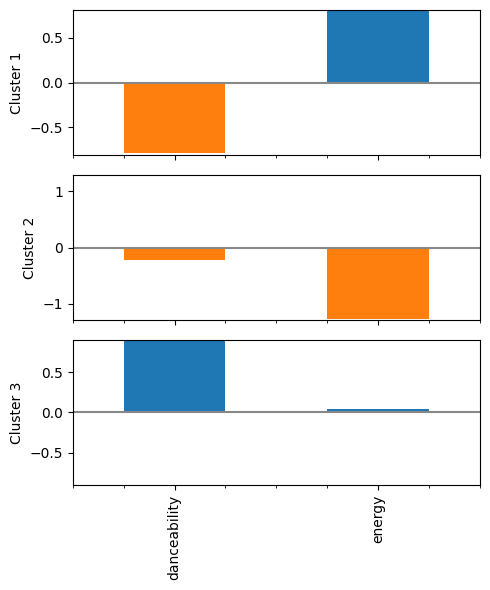

In [112]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=cols)

f, axes = plt.subplots(3, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

In [113]:
# Number of cluster can be driven by application 
# Methods to estimate best K -> silhouette method, elbow method

In [114]:
# Hierarchical clustering
# Intuitive graphical display
# Does not scale very well for large datasets
# distance metric -> distance between two records
# Dissimilarity measure -> Measure difference between cluster A and B based on the records of each

In [115]:
Z = linkage(dfcn.T, method='complete') # Cluster the variables 
print(Z.shape)

(8, 4)


In [116]:
# Agglomerative algorithm 
# Starts with each record as its own cluster and climbs up
# Record distance between each pair of records 
# Distance between clusters -> Complete linkage: D(A,B) = max([d(x,y) for (x,y) in product(A,B)])
# Measure the clusters that are least dissimilar
# Repeat until there is only one cluster

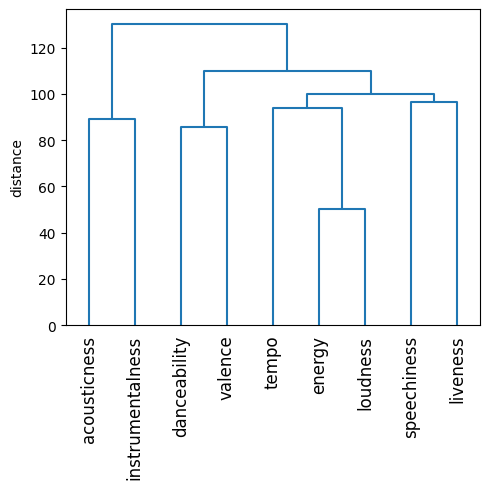

In [117]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(dfcn.columns), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

In [118]:
X = dfcn.T

In [119]:
from sklearn.metrics.pairwise import euclidean_distances
T = pd.DataFrame(euclidean_distances(X,X),index=X.index,columns=X.index)
np.fill_diagonal(T.values,np.inf)

In [120]:
T

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,inf,109.571112,103.030075,94.839214,93.551033,100.626650,104.431825,85.495591,109.917990
energy,109.571112,inf,50.009248,99.050327,130.188309,108.134540,90.503609,82.274970,89.720374
loudness,103.030075,50.009248,inf,100.111746,125.577515,114.605250,94.292342,88.217733,94.086951
speechiness,94.839214,99.050327,100.111746,inf,98.137186,103.315266,96.310642,99.684561,97.727570
acousticness,93.551033,130.188309,125.577515,98.137186,inf,89.023040,104.836956,110.150270,107.130956
instrumentalness,100.626650,108.134540,114.605250,103.315266,89.023040,inf,101.786165,107.256394,101.252453
liveness,104.431825,90.503609,94.292342,96.310642,104.836956,101.786165,inf,96.100261,99.489243
valence,85.495591,82.274970,88.217733,99.684561,110.150270,107.256394,96.100261,inf,96.473411
tempo,109.917990,89.720374,94.086951,97.727570,107.130956,101.252453,99.489243,96.473411,inf


In [138]:
# Model based clustering 
# Multivariate normal -> Generalization of the Normal dsitribution to a set of predictors. Vector of means and the covariance matrix
# Symmetric around diagonal. The entry ij represents the variance of the variable

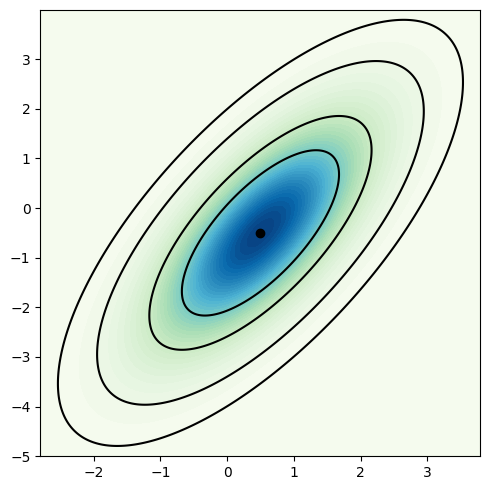

In [139]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

In [141]:
# Mixture of normals
# Each record is assumed to be drawn from one of K Multivariate Normal
X = dfcn[cols]
mclust = GaussianMixture(n_components=2).fit(X)
mclust.bic(X)

27537.70732989123

In [146]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

Mean
[[-0.23191479  0.76639656]
 [ 0.20819376 -0.68800693]]
Covariances
[[[ 0.93335888 -0.15602908]
  [-0.15602908  0.25517853]]

 [[ 0.96781934  0.06183865]
  [ 0.06183865  0.66762127]]]


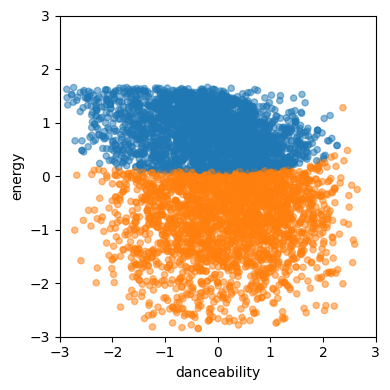

In [145]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(X)]
X.plot.scatter(x=cols[0], y=cols[1], c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [ ]:
# BIC -> Bayesian information criteria -> Penalize large number of K

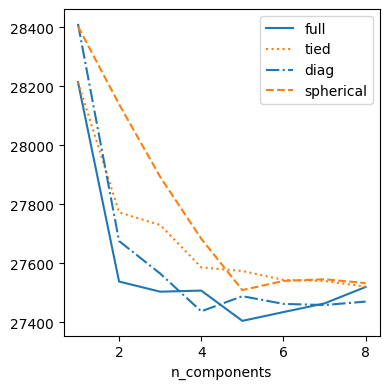

In [148]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(X)
        results.append({
            'bic': mclust.bic(X),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

In [ ]:
# Covariance type -> How the covariance is computed 
# Gaussian Mixture assumes the features to be normally distributed

In [149]:
# Unsupervised learning requires data to be scaled
# Binary data can be problematic to PCA and K-Means
# Categorical data -> Convert to one-hot-encoding or ordinal encoding
# Gower distance 
# Distance for every pair i,j
# Scale each dij pair such that the minimum is 0 and maximum is 1
# Add the pairwise scaled distances betwen variables together,using either a simple or weighted mean

In [ ]:
# Problems with mixed data
# Interpretation between numeric and categorical is different
# For large data, apply clustering based on specific categorical values.